### GloVe плюс линейная модель

Были подготовлены эмбеддинги для всего корпуса текстов пресс-релизов с помощью модели GloVe [https://github.com/stanfordnlp/GloVe](https://github.com/stanfordnlp/GloVe) c различной длиной вектора. Индекс векторов находится в каталоге `glove`.

In [2]:
import re
from string import punctuation

import pandas as pd
import numpy as np
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from pymystem3 import Mystem
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
import utils
import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 41825352
DATASET_URL = '../data/cbr-press-releases.csv'

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

Загрузка датасета:

In [3]:
df = pd.read_csv(DATASET_URL, parse_dates=['date'])
df['rate'] = df.rate.shift(1)
df.loc[0, 'rate'] = 5.5
df.set_index('date', inplace=True)
df.drop('link', axis=1, inplace=True)
df.sort_values('date', inplace=True)
cur_pr = df.tail(1)
df = df[:-1]
X = df.drop(['target_categorial', 'target_absolute', 'target_relative'], axis=1)
y = df['target_categorial']

In [4]:
metrics = pd.read_csv('metrics.csv', index_col=0)

Генерация векторов:

In [5]:
mystem = Mystem()
STOP_WORDS = set(stopwords.words('russian'))

def preprocessor(text):
    text = text.lower()
    regex = re.compile('[^а-я А-ЯЁё]')
    text = regex.sub(' ', text)
    text = ' '.join(mystem.lemmatize(text))
    return ' '.join([word for word in text.split()])

# сохраняем корпус текстов в файл
with open('releases.txt', 'tw', encoding='utf-8') as f:
    for x in X.release.apply(preprocessor):
        f.write(x)
        f.write(' ')

# далее вызываем построение векторов при помощи glove для заданного размера вектора:
# vocab_count -min-count 5 -verbose 2 < releases.txt > vocab.txt
# cooccur -memory 4.0 -vocab-file vocab.txt -verbose 2 -window-size 15 < releases.txt > cooccurrence.bin
# shuffle -memory 4.0 -verbose 2 < cooccurrence.bin > cooccurrence.shuf.bin
# glove -save-file vectors -threads 8 -input-file cooccurrence.shuf.bin -x-max 10 -iter 15 -vector-size 50 -binary 2 -vocab-file vocab.txt -verbose 2

Класс преобразования документа в вектор на основе индекса векторов:

In [6]:
class GloveVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, vectors_file, *, preprocessor=None, vector_size=-1):
        self._preprocessor = preprocessor
        self._vectors = {}
        
        with open(vectors_file, encoding="utf8") as f:
            for line in f:
                word, *vector = line.split()
                self._vectors[word] = np.array(vector, dtype=float)
                max_size = len(vector)
        
        self._vector_size = vector_size if vector_size >= 0 and vector_size < max_size else max_size
    
    
    def fit(self, X, y=None):
        return self
    
    
    def transform(self, X):
        if self._preprocessor:
            X = X.apply(self._preprocessor).tolist()
        
        return np.array([
            np.mean([self._vectors[w][:self._vector_size] for w in words if w in self._vectors] 
                    or [np.zeros(self._vector_size)], axis=0)
            for words in X
        ])

In [7]:
def preprocessor(text):
    text = text.lower()
    regex = re.compile('[^а-я А-ЯЁё]')
    text = regex.sub(' ', text)
    text = ' '.join(mystem.lemmatize(text))
    return [
        word for word in text.split()
        if word not in STOP_WORDS
    ]


Подберем оптимальную длину вектора и параметры для SVM:

In [8]:
from sklearn.preprocessing import StandardScaler


auc = []
for vec_size in tqdm([50, 70, 90, 100]):
    vectorizer = GloveVectorizer(f'glove/vectors.100d.txt', preprocessor=preprocessor, vector_size=vec_size)
    glove = vectorizer.fit_transform(X.release)
    glove = StandardScaler().fit_transform(glove)
    
    for c in [0.01, 0.05, 0.1, 0.5, 1, 3, 5, 7, 10]:
        for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
            auc.append(
                utils.calc_metrics(
                    glove, y,
                    SVC,
                    name='glove svc only release', 
                    kernel=kernel,
                    C=c,
                    plot=False, 
                    probability=True,
                    random_state=RANDOM_STATE
                    ) + (glove,)
                )

roc_auc, best_model, glove = max(auc, key=lambda x: x[0])

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")
print(f"Vector size = {glove.shape[1]}")

100%|██████████| 4/4 [00:26<00:00,  6.55s/it]

Лучшая модель - SVC(C=3, probability=True, random_state=41825352)
ROC-AUC = 0.7635972039178446
Vector size = 70


              precision    recall  f1-score   support

        -1.0       0.67      0.61      0.64        23
         0.0       0.49      0.71      0.58        24
         1.0       0.90      0.47      0.62        19

    accuracy                           0.61        66
   macro avg       0.68      0.60      0.61        66
weighted avg       0.67      0.61      0.61        66



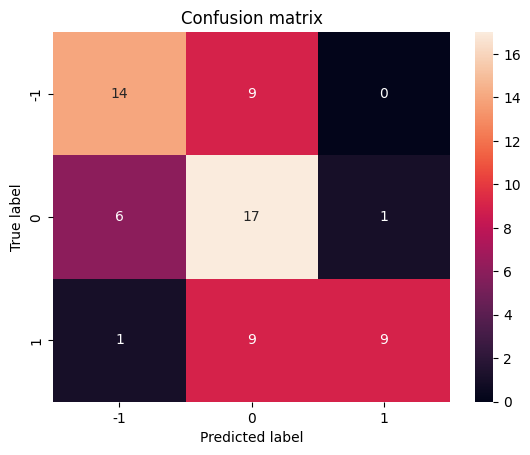

,accuracy,f1,precision,recall,roc_auc_ovr
min_baseline,0.663158,0.667893,0.669919,0.666111,NaN
bow l1 only release,0.621212,0.627058,0.642995,0.619311,0.769110
bow elasticnet,0.681818,0.686510,0.705556,0.678521,0.861207
bow release title,0.681818,0.686510,0.705556,0.678521,0.861207
bow release all num,0.696970,0.698591,0.708400,0.693618,0.858634
bow svc only release,0.666667,0.676367,0.695838,0.667684,0.836664
tf_idf l1 only release,0.606061,0.613057,0.643850,0.601767,0.784513
tf_idf only release best word,0.757576,0.761220,0.769459,0.756484,0.901979
tf_idf title release,0.712121,0.717903,0.737500,0.709954,0.878747
tf_idf numerical release,0.681818,0.688457,0.731248,0.677314,0.835872


In [9]:
metric, model = utils.calc_metrics(glove, y, SVC, name='glove svc only release', **best_model.get_params())
metrics = pd.concat([metrics, metric], axis=0)
metrics

Как и в случае Word2Vec, качество лучшей модели получилось хуже минимального бейзлайна.

In [10]:
metrics.to_csv('metrics.csv')